# US Currency Classification Using PyTorch with PSO Optimization



## 1. Import Libraries



In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import imghdr
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models
import torchvision.transforms as transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Data Preparation



In [2]:
# Set paths to your data directories
data_dir = "USA currency data"
image_exts = ['jpeg', 'jpg', 'png']

# Check if directory exists
if os.path.exists(data_dir):
    print("Data directory found. Listing classes:")
    for image_class in os.listdir(data_dir):
        print(image_class)
else:
    print(f"Data directory '{data_dir}' not found. Please update the path.")

Data directory found. Listing classes:
1 Dollar
10 Dollar
100 Dollar
2 Dollar
5 Dollar
50 Dollar


In [3]:
# Remove corrupted images
def remove_corrupted_images():
    for image_class in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print(f'Image not in ext list {image_path}')
                    os.remove(image_path)
                else:
                    with Image.open(image_path) as im:
                        # Remove ICC profile
                        im.info.pop('icc_profile', None)
                        im.save(image_path)
            except Exception as e:
                print(f'Issue with image {image_path}: {e}')
                os.remove(image_path)

# Uncomment to run the cleaning process
# remove_corrupted_images()

In [4]:
# Load and process images
X = []
Z = []
img_size = 224

def assign_label(img, currency_type):
    return currency_type

def make_train_data(currency_type, dir_path):
    if not os.path.exists(dir_path):
        print(f"Directory not found: {dir_path}")
        return
    
    for img in tqdm(os.listdir(dir_path)):
        label = assign_label(img, currency_type)
        path = os.path.join(dir_path, img)
        try:
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (img_size, img_size))
            X.append(np.array(img))
            Z.append(str(label))
        except Exception as e:
            print(f"Error processing {path}: {e}")

# Process each currency denomination
currency_dirs = {
    'One': os.path.join(data_dir, '1 Dollar'),
    'Two': os.path.join(data_dir, '2 Dollar'),
    'Five': os.path.join(data_dir, '5 Dollar'),
    'Ten': os.path.join(data_dir, '10 Dollar'),
    'Fifty': os.path.join(data_dir, '50 Dollar'),
    'Hundred': os.path.join(data_dir, '100 Dollar')
}

for currency_type, dir_path in currency_dirs.items():
    make_train_data(currency_type, dir_path)

print(f"Total number of images loaded: {len(X)}")

100%|██████████| 618/618 [00:03<00:00, 191.85it/s]

Total number of images loaded: 3904


In [5]:
# Shuffle the data
X, Z = shuffle(X, Z, random_state=42)

# Normalize images and encode labels
X = np.array(X) / 255.0
le = LabelEncoder()
Y = le.fit_transform(Z)
num_classes = len(np.unique(Y))

# Display class mapping
class_mapping = {i: label for i, label in enumerate(le.classes_)}
print("Class mapping:")
for idx, label in class_mapping.items():
    print(f"Class {idx}: {label}")

# Split the data
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=1/3, random_state=42)  # 20% val, 10% test

print(f"Number of training images: {len(X_train)}")
print(f"Number of validation images: {len(X_val)}")
print(f"Number of test images: {len(X_test)}")

Class mapping:
Class 0: Fifty
Class 1: Five
Class 2: Hundred
Class 3: One
Class 4: Ten
Class 5: Two
Number of training images: 2732
Number of validation images: 781
Number of test images: 391


In [6]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).permute(0, 3, 1, 2)  # Change from (N, H, W, C) to (N, C, H, W)
Y_train_tensor = torch.LongTensor(Y_train)

X_val_tensor = torch.FloatTensor(X_val).permute(0, 3, 1, 2)
Y_val_tensor = torch.LongTensor(Y_val)

X_test_tensor = torch.FloatTensor(X_test).permute(0, 3, 1, 2)
Y_test_tensor = torch.LongTensor(Y_test)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# We'll set batch_size later during PSO optimization
batch_size = 32  # Default value, will be optimized by PSO

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 3. Define the PyTorch Model



In [7]:
class CurrencyClassifier(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.2, fc_units=1024, l2_reg=0.01):
        super(CurrencyClassifier, self).__init__()
        # Load pre-trained ResNet50
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer
        self.base_model.fc = nn.Identity()  # Remove the original fc layer
        
        # Add custom layers
        self.fc1 = nn.Linear(2048, fc_units)  # ResNet50 outputs 2048 features
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc_units, num_classes)
        
        # Store L2 regularization strength for optimizer
        self.l2_reg = l2_reg
        
    def forward(self, x):
        x = self.base_model(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 4. Define Training and Evaluation Functions

In [8]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    model.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model, history, best_val_acc

In [9]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy

In [10]:
def plot_history(history):
    plt.figure(figsize=(14, 6))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    plt.show()

## 5. Train the Baseline Model (Without Optimization)



c:\Users\PCCV\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PCCV\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training the baseline model with default hyperparameters...
Epoch 1/20 - Train Loss: 1.1588, Train Acc: 0.6973 - Val Loss: 0.6830, Val Acc: 0.8720
Epoch 2/20 - Train Loss: 0.5554, Train Acc: 0.8862 - Val Loss: 0.4478, Val Acc: 0.8976
Epoch 3/20 - Train Loss: 0.3674, Train Acc: 0.9242 - Val Loss: 0.3126, Val Acc: 0.9462
Epoch 4/20 - Train Loss: 0.2954, Train Acc: 0.9370 - Val Loss: 0.2947, Val Acc: 0.9321
Epoch 5/20 - Train Loss: 0.2570, Train Acc: 0.9425 - Val Loss: 0.2336, Val Acc: 0.9501
Epoch 6/20 - Train Loss: 0.2181, Train Acc: 0.9520 - Val Loss: 0.2221, Val Acc: 0.9475
Epoch 7/20 - Train Loss: 0.1901, Train Acc: 0.9608 - Val Loss: 0.2327, Val Acc: 0.9488
Epoch 8/20 - Train Loss: 0.1880, Train Acc: 0.9630 - Val Loss: 0.1941, Val Acc: 0.9552
Epoch 9/20 - Train Loss: 0.1648, Train Acc: 0.9663 - Val Loss: 0.1999, Val Acc: 0.9565
Epoch 10/20 - Train Loss: 0.1599, Train Acc: 0.9674 - Val Loss: 0.1681, Val Acc: 0.9590
Epoch 11/20 - Train Loss: 0.1598, Train Acc: 0.9638 - Val Loss: 0.171

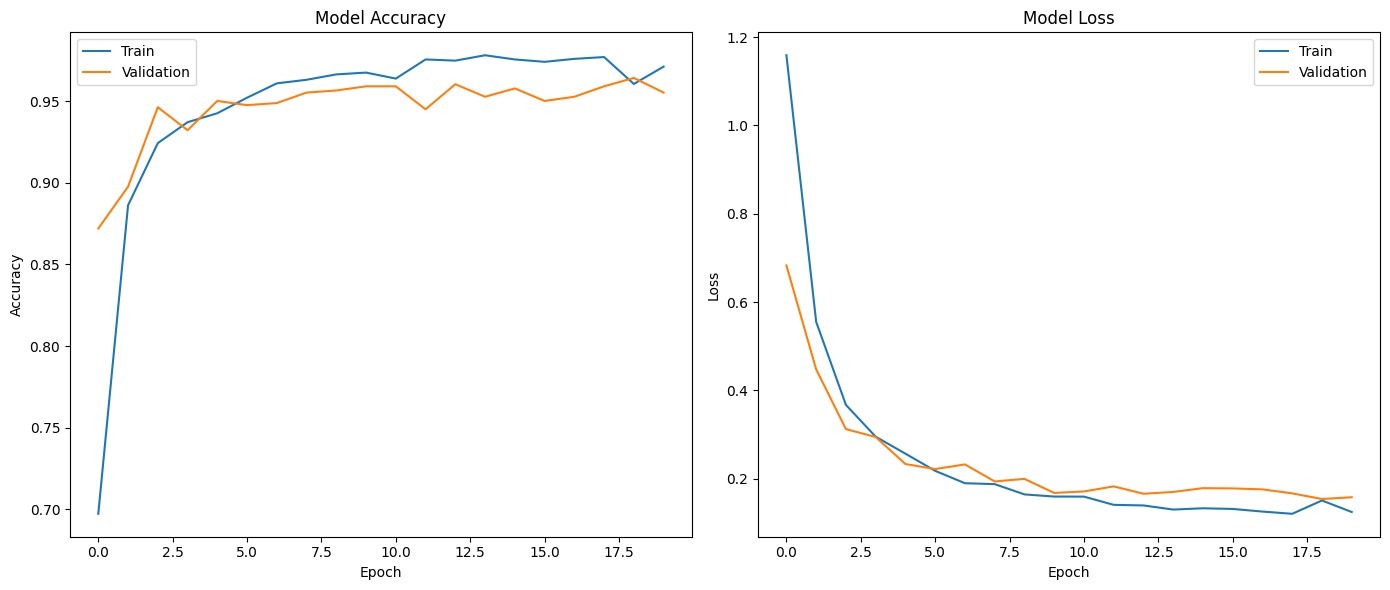

In [11]:
# Define default hyperparameters for the baseline model
default_learning_rate = 0.0001
default_dropout_rate = 0.2
default_l2_reg = 0.01
default_fc_units = 1024
default_batch_size = 32

# Create dataloaders with the default batch size
train_loader = DataLoader(train_dataset, batch_size=default_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=default_batch_size)
test_loader = DataLoader(test_dataset, batch_size=default_batch_size)

# Create the baseline model
baseline_model = CurrencyClassifier(
    num_classes=num_classes,
    dropout_rate=default_dropout_rate,
    fc_units=default_fc_units,
    l2_reg=default_l2_reg
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=default_learning_rate, weight_decay=default_l2_reg)

# Train the baseline model
print("Training the baseline model with default hyperparameters...")
baseline_model, baseline_history, baseline_val_acc = train_model(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=20  
)

# Plot training history
plot_history(baseline_history)

Evaluating the baseline model on the test set...
Test Accuracy: 0.9591

Classification Report:
              precision    recall  f1-score   support

       Fifty       0.90      0.97      0.94        74
        Five       1.00      0.83      0.91        72
     Hundred       1.00      0.98      0.99        58
         One       0.95      1.00      0.97        52
         Ten       0.94      1.00      0.97        73
         Two       1.00      0.98      0.99        62

    accuracy                           0.96       391
   macro avg       0.96      0.96      0.96       391
weighted avg       0.96      0.96      0.96       391



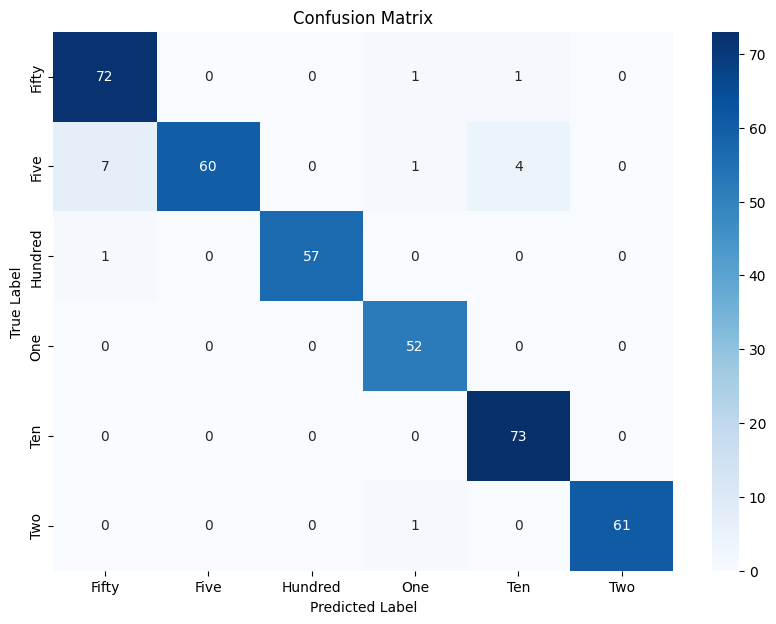


Baseline Model Test Accuracy: 0.9591
Baseline Model Best Validation Accuracy: 0.9641
Baseline model saved as 'currency_classifier_baseline.pth'


In [12]:
# Evaluate the baseline model on the test set
class_names = list(class_mapping.values())
print("Evaluating the baseline model on the test set...")
baseline_test_accuracy = evaluate_model(baseline_model, test_loader, class_names)

print(f"\nBaseline Model Test Accuracy: {baseline_test_accuracy:.4f}")
print(f"Baseline Model Best Validation Accuracy: {baseline_val_acc:.4f}")

# Save the baseline model
torch.save(baseline_model.state_dict(), 'currency_classifier_baseline.pth')
print("Baseline model saved as 'currency_classifier_baseline.pth'")

## 6. Implement Particle Swarm Optimization (PSO)



In [13]:
class Particle:
    def __init__(self, bounds):
        # Initialize position and velocity
        self.position = {}
        self.velocity = {}
        
        for param, (min_val, max_val) in bounds.items():
            if param == 'batch_size' or param == 'fc_units':
                # Integer parameters
                self.position[param] = random.randint(min_val, max_val)
                self.velocity[param] = random.uniform(-1, 1)
            else:
                # Float parameters
                self.position[param] = random.uniform(min_val, max_val)
                self.velocity[param] = random.uniform(-0.1, 0.1)
        
        # Initialize best position and fitness
        self.best_position = self.position.copy()
        self.best_fitness = -float('inf')
        self.current_fitness = -float('inf')
    
    def update_velocity(self, global_best_position, w=0.7, c1=1.5, c2=1.5):
        for param in self.position.keys():
            # Cognitive component (personal best)
            r1 = random.random()
            cognitive = c1 * r1 * (self.best_position[param] - self.position[param])
            
            # Social component (global best)
            r2 = random.random()
            social = c2 * r2 * (global_best_position[param] - self.position[param])
            
            # Update velocity
            self.velocity[param] = w * self.velocity[param] + cognitive + social
    
    def update_position(self, bounds):
        for param, (min_val, max_val) in bounds.items():
            # Update position
            self.position[param] += self.velocity[param]
            
            # Ensure position is within bounds
            if param == 'batch_size' or param == 'fc_units':
                # Integer parameters
                self.position[param] = int(self.position[param])
                self.position[param] = max(min_val, min(max_val, self.position[param]))
            else:
                # Float parameters
                self.position[param] = max(min_val, min(max_val, self.position[param]))
    
    def update_best(self, fitness):
        self.current_fitness = fitness
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_position = self.position.copy()

In [14]:
class PSO:
    def __init__(self, bounds, num_particles=10, max_iter=10, w=0.7, c1=1.5, c2=1.5):
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive coefficient
        self.c2 = c2  # Social coefficient
        
        # Initialize particles
        self.particles = [Particle(bounds) for _ in range(num_particles)]
        
        # Initialize global best
        self.global_best_position = None
        self.global_best_fitness = -float('inf')
        
        # History for plotting
        self.history = {
            'global_best_fitness': [],
            'avg_fitness': []
        }
    
    def optimize(self, fitness_function):
        # Initialize global best from first evaluations
        for particle in self.particles:
            fitness = fitness_function(particle.position)
            particle.update_best(fitness)
            
            if fitness > self.global_best_fitness:
                self.global_best_fitness = fitness
                self.global_best_position = particle.position.copy()
        
        # Main PSO loop
        for iteration in range(self.max_iter):
            print(f"\nIteration {iteration+1}/{self.max_iter}")
            
            # Update each particle
            for particle in self.particles:
                # Update velocity and position
                particle.update_velocity(self.global_best_position, self.w, self.c1, self.c2)
                particle.update_position(self.bounds)
                
                # Evaluate fitness
                fitness = fitness_function(particle.position)
                particle.update_best(fitness)
                
                # Update global best
                if fitness > self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = particle.position.copy()
            
            # Calculate average fitness for this iteration
            avg_fitness = sum(p.current_fitness for p in self.particles) / self.num_particles
            
            # Update history
            self.history['global_best_fitness'].append(self.global_best_fitness)
            self.history['avg_fitness'].append(avg_fitness)
            
            # Print current best
            print(f"Global Best Fitness: {self.global_best_fitness:.4f}")
            print(f"Global Best Position: {self.global_best_position}")
            print(f"Average Fitness: {avg_fitness:.4f}")
        
        return self.global_best_position, self.global_best_fitness, self.history

In [15]:
def plot_pso_history(history):
    plt.figure(figsize=(12, 6))
    
    plt.plot(history['global_best_fitness'], 'r-', label='Global Best Fitness')
    plt.plot(history['avg_fitness'], 'b--', label='Average Fitness')
    
    plt.title('PSO Optimization Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (Validation Accuracy)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def fitness_function(hyperparams):
    # Extract hyperparameters
    learning_rate = hyperparams['learning_rate']
    dropout_rate = hyperparams['dropout_rate']
    l2_reg = hyperparams['l2_reg']
    fc_units = hyperparams['fc_units']
    batch_size = hyperparams['batch_size']
    
    # Create dataloaders with the current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Create model with current hyperparameters
    model = CurrencyClassifier(num_classes=num_classes, dropout_rate=dropout_rate, 
                              fc_units=fc_units, l2_reg=l2_reg)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    
    # Train for a few epochs to evaluate fitness
    model.to(device)
    num_epochs = 10  # Use fewer epochs for PSO to speed up optimization
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate validation accuracy as fitness
    val_accuracy = correct / total
    print(f"Hyperparams: {hyperparams}, Validation Accuracy: {val_accuracy:.4f}")
    
    return val_accuracy

In [17]:
# Define hyperparameter bounds for PSO
hyperparameter_bounds = {
    'learning_rate': (0.00005, 0.01),
    'dropout_rate': (0.1, 0.4),
    'l2_reg': (0.0005, 0.05),
    'fc_units': (512, 2048),
    'batch_size': (16, 64)
}

# Initialize PSO
pso = PSO(
    bounds=hyperparameter_bounds,
    num_particles=20,  # Using fewer particles for efficiency
    max_iter=20,       # Using fewer iterations for efficiency
    w=0.7,            # Inertia weight
    c1=1.5,           # Cognitive coefficient
    c2=1.5            # Social coefficient
)

# Run PSO optimization
best_hyperparams, best_fitness, pso_history = pso.optimize(fitness_function)

print("\nPSO Optimization Complete")
print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best Validation Accuracy: {best_fitness:.4f}")

c:\Users\PCCV\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PCCV\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Hyperparams: {'learning_rate': 0.001836713688187805, 'dropout_rate': 0.27582963942426064, 'l2_reg': 0.012648802243759912, 'fc_units': 1248, 'batch_size': 59}, Validation Accuracy: 0.9219
Hyperparams: {'learning_rate': 0.001761618843276117, 'dropout_rate': 0.3209569875958942, 'l2_reg': 0.03648587101330013, 'fc_units': 740, 'batch_size': 31}, Validation Accuracy: 0.8848
Hyperparams: {'learning_rate': 0.006106754965946771, 'dropout_rate': 0.17492247912098569, 'l2_reg': 0.046393284364419626, 'fc_units': 1410, 'batch_size': 25}, Validation Accuracy: 0.7951
Hyperparams: {'learning_rate': 0.001660881396395681, 'dropout_rate': 0.17724131449926211, 'l2_reg': 0.047877044497784405, 'fc_units': 1351, 'batch_size': 34}, Validation Accuracy: 0.8937
Hyperparams: {'learning_rate': 0.006005545089589852, 'dropout_rate': 0.31591679294736985, 'l2_reg': 0.005425040829051642, 'fc_units': 1189, 'batch_size': 62}, Validation Accuracy: 0.8976
Hyperparams: {'learning_rate': 0.0016373744584841966, 'dropout_rate'

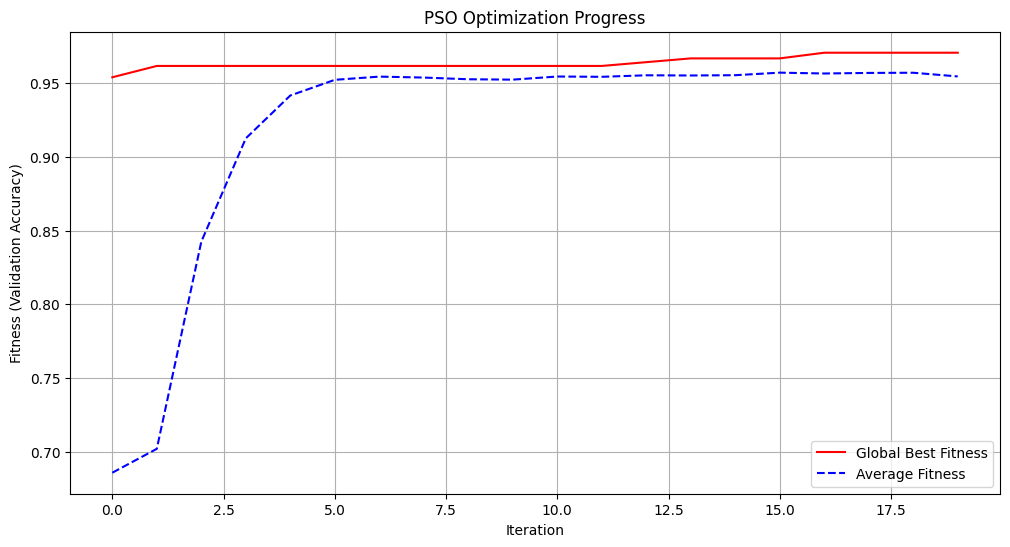

In [18]:
# Plot PSO optimization history
plot_pso_history(pso_history)

## 7. Train the Model with Optimized Hyperparameters



Training the model with optimized hyperparameters...
Epoch 1/20 - Train Loss: 0.9474, Train Acc: 0.6783 - Val Loss: 0.4492, Val Acc: 0.8771
Epoch 2/20 - Train Loss: 0.3918, Train Acc: 0.8887 - Val Loss: 0.2613, Val Acc: 0.9309
Epoch 3/20 - Train Loss: 0.2843, Train Acc: 0.9158 - Val Loss: 0.2371, Val Acc: 0.9385
Epoch 4/20 - Train Loss: 0.2498, Train Acc: 0.9195 - Val Loss: 0.1568, Val Acc: 0.9590
Epoch 5/20 - Train Loss: 0.1893, Train Acc: 0.9451 - Val Loss: 0.1695, Val Acc: 0.9539
Epoch 6/20 - Train Loss: 0.1594, Train Acc: 0.9528 - Val Loss: 0.2063, Val Acc: 0.9437
Epoch 7/20 - Train Loss: 0.1749, Train Acc: 0.9436 - Val Loss: 0.1300, Val Acc: 0.9565
Epoch 8/20 - Train Loss: 0.1521, Train Acc: 0.9520 - Val Loss: 0.1728, Val Acc: 0.9526
Epoch 9/20 - Train Loss: 0.1373, Train Acc: 0.9542 - Val Loss: 0.1441, Val Acc: 0.9603
Epoch 10/20 - Train Loss: 0.1206, Train Acc: 0.9601 - Val Loss: 0.1450, Val Acc: 0.9654
Epoch 11/20 - Train Loss: 0.1300, Train Acc: 0.9616 - Val Loss: 0.1170, Val 

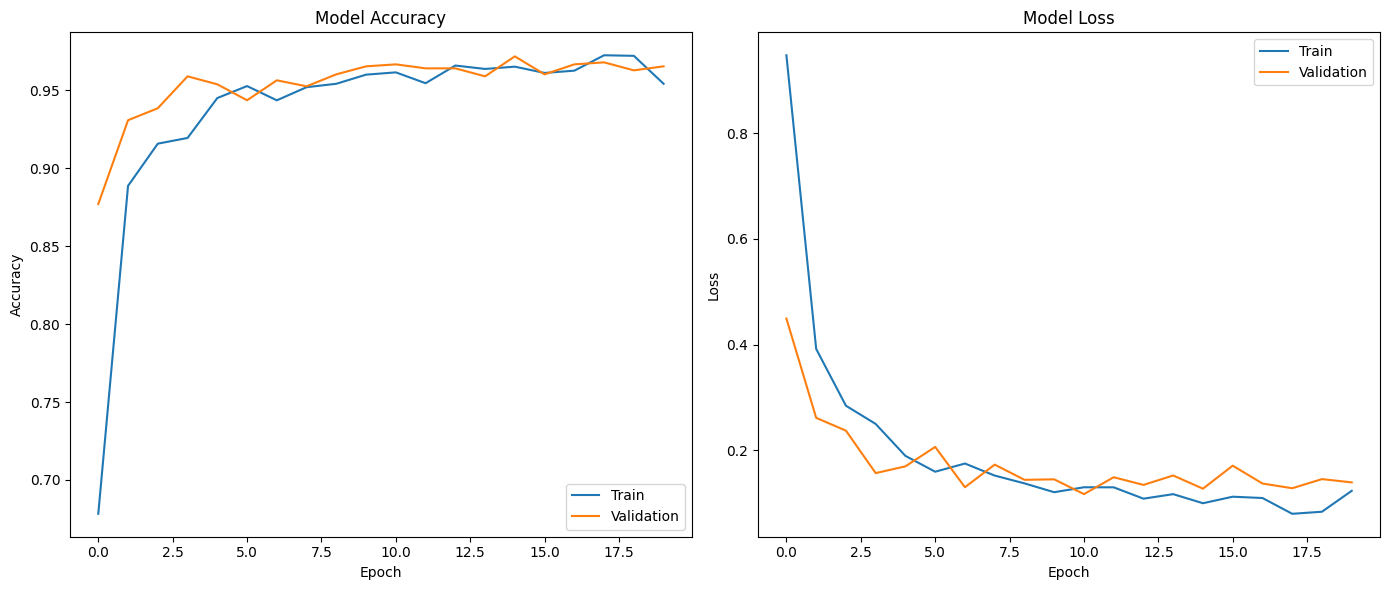

In [19]:
# Extract best hyperparameters
best_learning_rate = best_hyperparams['learning_rate']
best_dropout_rate = best_hyperparams['dropout_rate']
best_l2_reg = best_hyperparams['l2_reg']
best_fc_units = best_hyperparams['fc_units']
best_batch_size = best_hyperparams['batch_size']

# Create dataloaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size)

# Create model with best hyperparameters
optimized_model = CurrencyClassifier(
    num_classes=num_classes,
    dropout_rate=best_dropout_rate,
    fc_units=best_fc_units,
    l2_reg=best_l2_reg
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(optimized_model.parameters(), lr=best_learning_rate, weight_decay=best_l2_reg)

# Train the model
print("Training the model with optimized hyperparameters...")
optimized_model, history, best_val_acc = train_model(
    model=optimized_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=20  
)

# Plot training history
plot_history(history)

## 8. Evaluate the Optimized Model



Evaluating the optimized model on the test set...
Test Accuracy: 0.9821

Classification Report:
              precision    recall  f1-score   support

       Fifty       0.96      0.97      0.97        74
        Five       1.00      0.96      0.98        72
     Hundred       1.00      0.98      0.99        58
         One       0.96      1.00      0.98        52
         Ten       0.97      1.00      0.99        73
         Two       1.00      0.98      0.99        62

    accuracy                           0.98       391
   macro avg       0.98      0.98      0.98       391
weighted avg       0.98      0.98      0.98       391



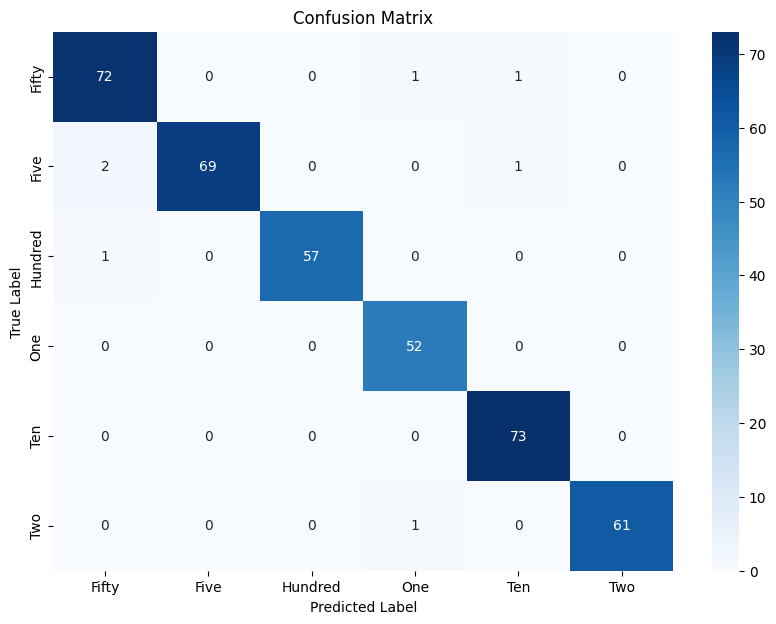


Final Test Accuracy: 0.9821
Best Validation Accuracy: 0.9718


In [20]:
# Get class names for evaluation
class_names = list(class_mapping.values())

# Evaluate the optimized model
print("Evaluating the optimized model on the test set...")
test_accuracy = evaluate_model(optimized_model, test_loader, class_names)

print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

## 9. Save the Optimized Model

In [21]:
# Save the model
torch.save(optimized_model.state_dict(), 'currency_classifier_pso_optimized.pth')
print("Model saved as 'currency_classifier_pso_optimized.pth'")

# Save hyperparameters
import json
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparams, f)
print("Hyperparameters saved as 'best_hyperparameters.json'")

Model saved as 'currency_classifier_pso_optimized.pth'
Hyperparameters saved as 'best_hyperparameters.json'


## 10. Compare baseline and optimized model performance


Performance Comparison:
Baseline Model Test Accuracy: 0.9591
PSO-Optimized Model Test Accuracy: 0.9821
Improvement: 2.30%


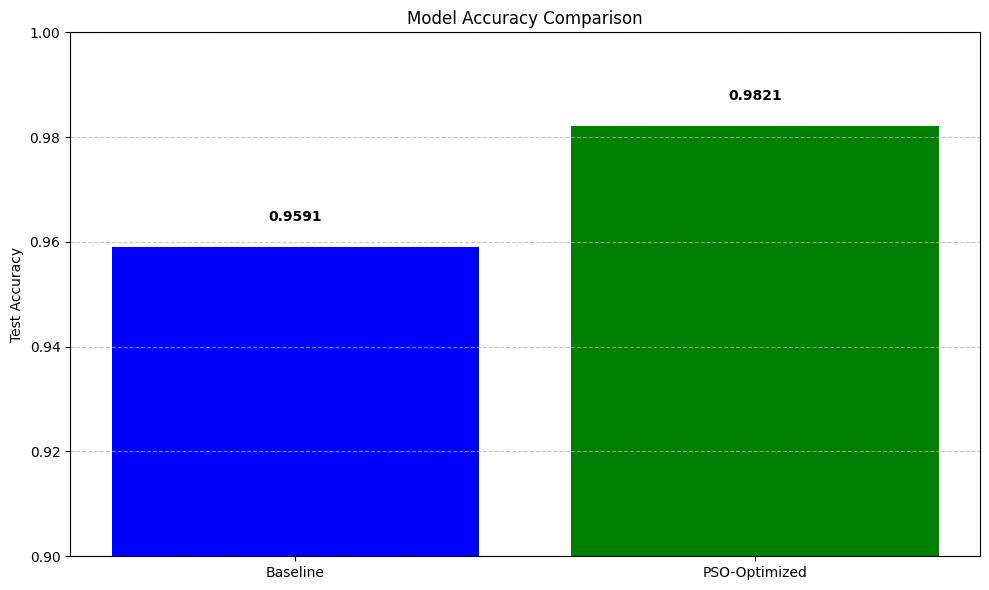

In [22]:
# Compare baseline and optimized model performance
print("Performance Comparison:")
print(f"Baseline Model Test Accuracy: {baseline_test_accuracy:.4f}")
print(f"PSO-Optimized Model Test Accuracy: {test_accuracy:.4f}")
print(f"Improvement: {(test_accuracy - baseline_test_accuracy) * 100:.2f}%")

# Plot comparison
models = ['Baseline', 'PSO-Optimized']
accuracies = [baseline_test_accuracy, test_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylim(0.9, 1.0)  # Adjust as needed based on your results
plt.title('Model Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f'{acc:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 11. GUI Interface for Testing Models

This section provides a graphical user interface to test and compare the baseline model and PSO-optimized model.